In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [2]:
import numpy as np
import torch
import VIT8
import tqdm
import random
device = torch.device('cuda')

In [3]:
def cvt_data_loader(x,y=None,batch_size= 32,shuffle = True):
    if y is None:
        return torch.utils.data.DataLoader(torch.tensor(x,dtype = torch.float32),batch_size= batch_size,shuffle=shuffle)
    
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(x,dtype = torch.float32),
                              torch.tensor(y,dtype = torch.float32))
                              ,batch_size= batch_size,shuffle=shuffle)
def cvt_one_hot(y,num_classes):
    one_hot = np.zeros((len(y),num_classes))
    one_hot[np.arange(len(y)),y] = 1
    return one_hot

In [4]:
train_dl_lis = []
batch_szie = 200
for i in range(20):
    data = np.load(f'cifar-10-augmented{i}.npz')
    x_train, y_train,  = np.array(data['x_train_aug'],dtype = np.float32)/ 255, data['y_train_aug']
    x_train = x_train.transpose(0,3,1,2)
    y_train = cvt_one_hot(y_train,10)
    train_dl = cvt_data_loader(x_train, y_train, batch_szie, True)
    train_dl_lis.append(train_dl)
x_test, y_test =  np.array(data['x_test'],dtype = np.float32)/255, data['y_test']
x_test = x_test.transpose(0,3,1,2)
y_test = cvt_one_hot(y_test,10)
test_dl = cvt_data_loader(x_test, y_test, batch_szie, True)

In [5]:
model = VIT8.VIT(embedDim=288,num_classes=10,numHeads=12,numLayers=8)

In [6]:
epochs = 150
critarion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, weight_decay= 5e-4)
seheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epochs,eta_min= 5e-7)

In [ ]:
model = model.to(device)
model = model.train()
train_loss = []
test_loss = []
train_accu = []
test_accu = []
max_accu = 0
min_loss = 1000
tf = True
for epoch in range(1, epochs + 1):
    print(f"Epoch : {epoch}")
    sum_loss = 0
    sum_accu = 0
    model = model.train()
    ind = random.randint(0,len(train_dl_lis) - 1)
    print(f"Using Training Data {ind}")
    train_dl=train_dl_lis[ind]
    for x, y in tqdm.tqdm(train_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(),torch.tensor(1))
        optimizer.step()
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    optimizer.zero_grad()
    seheduler.step()
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(train_dl.dataset)
    sum_accu = sum_accu / len(train_dl.dataset)
    print(f"Train Accuracy : {sum_accu}")
    print(f"Train Loss : {sum_loss}")
    train_loss.append(sum_loss)
    train_accu.append(sum_accu)
    sum_loss = 0
    sum_accu = 0
    model = model.eval()
    for x, y in tqdm.tqdm(test_dl):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        out = model.forward(x)
        loss = critarion(out, y)
        sum_loss += float(loss) * len(x)
        sum_accu += float(torch.sum(torch.argmax(out,dim = 1)==torch.argmax(y,dim=1)))
    torch.cuda.empty_cache()
    sum_loss = sum_loss/ len(test_dl.dataset)
    sum_accu = sum_accu / len(test_dl.dataset)
    if sum_accu > max_accu:
        max_accu = sum_accu
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"VIT_accu")
    if sum_loss < min_loss:
        min_loss = sum_loss
        torch.save({'state_dict' : model.state_dict(), 'cfgDict' : model.cfgDict},"VIT_loss")
    print(f"Val Accuracy : {sum_accu}")
    print(f"Val Loss : {sum_loss}")
    test_accu.append(sum_accu)
    test_loss.append(sum_loss)

Epoch : 1
Using Training Data 8


100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


Train Accuracy : 0.2781
Train Loss : 1.8651429738998413


100%|██████████| 50/50 [00:01<00:00, 35.16it/s]


Val Accuracy : 0.3524
Val Loss : 1.678737654685974
Epoch : 2
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.38656
Train Loss : 1.6140574440956115


100%|██████████| 50/50 [00:01<00:00, 36.18it/s]


Val Accuracy : 0.4407
Val Loss : 1.528907129764557
Epoch : 3
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.48022
Train Loss : 1.4071055445671081


100%|██████████| 50/50 [00:01<00:00, 36.74it/s]


Val Accuracy : 0.5378
Val Loss : 1.2896577000617981
Epoch : 4
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.70it/s]


Train Accuracy : 0.5435
Train Loss : 1.2645218558311462


100%|██████████| 50/50 [00:01<00:00, 36.61it/s]


Val Accuracy : 0.5812
Val Loss : 1.1702433252334594
Epoch : 5
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.58982
Train Loss : 1.1495351898670196


100%|██████████| 50/50 [00:01<00:00, 36.42it/s]


Val Accuracy : 0.6063
Val Loss : 1.1457601404190063
Epoch : 6
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.65it/s]


Train Accuracy : 0.61946
Train Loss : 1.0695910053253175


100%|██████████| 50/50 [00:01<00:00, 36.34it/s]


Val Accuracy : 0.6836
Val Loss : 0.910147442817688
Epoch : 7
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.66it/s]


Train Accuracy : 0.65146
Train Loss : 0.9951149611473084


100%|██████████| 50/50 [00:01<00:00, 36.79it/s]


Val Accuracy : 0.6868
Val Loss : 0.8894246900081635
Epoch : 8
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.65it/s]


Train Accuracy : 0.66882
Train Loss : 0.9438078696727753


100%|██████████| 50/50 [00:01<00:00, 36.38it/s]


Val Accuracy : 0.7302
Val Loss : 0.7936999011039734
Epoch : 9
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.49it/s]


Train Accuracy : 0.68568
Train Loss : 0.894891194820404


100%|██████████| 50/50 [00:01<00:00, 35.55it/s]


Val Accuracy : 0.7229
Val Loss : 0.8157103371620178
Epoch : 10
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.69874
Train Loss : 0.8606009759902954


100%|██████████| 50/50 [00:01<00:00, 36.08it/s]


Val Accuracy : 0.7122
Val Loss : 0.8329911017417908
Epoch : 11
Using Training Data 6


100%|██████████| 250/250 [00:22<00:00, 11.33it/s]


Train Accuracy : 0.71082
Train Loss : 0.8283353269100189


100%|██████████| 50/50 [00:01<00:00, 35.54it/s]


Val Accuracy : 0.7607
Val Loss : 0.7203584861755371
Epoch : 12
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.46it/s]


Train Accuracy : 0.7216
Train Loss : 0.8024538190364837


100%|██████████| 50/50 [00:01<00:00, 36.90it/s]


Val Accuracy : 0.7585
Val Loss : 0.7038555347919464
Epoch : 13
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.76it/s]


Train Accuracy : 0.73248
Train Loss : 0.7683795022964478


100%|██████████| 50/50 [00:01<00:00, 36.70it/s]


Val Accuracy : 0.7654
Val Loss : 0.6781382215023041
Epoch : 14
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.78it/s]


Train Accuracy : 0.7641
Train Loss : 0.6825453916788101


100%|██████████| 50/50 [00:01<00:00, 36.83it/s]


Val Accuracy : 0.7666
Val Loss : 0.6945148801803589
Epoch : 15
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.70it/s]


Train Accuracy : 0.74642
Train Loss : 0.7353004598617554


100%|██████████| 50/50 [00:01<00:00, 36.54it/s]


Val Accuracy : 0.7721
Val Loss : 0.6820236659049987
Epoch : 16
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.75it/s]


Train Accuracy : 0.78654
Train Loss : 0.6162045774459839


100%|██████████| 50/50 [00:01<00:00, 36.75it/s]


Val Accuracy : 0.7756
Val Loss : 0.682432255744934
Epoch : 17
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


Train Accuracy : 0.7664
Train Loss : 0.6729391765594482


100%|██████████| 50/50 [00:01<00:00, 36.36it/s]


Val Accuracy : 0.7882
Val Loss : 0.6467328989505767
Epoch : 18
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.77164
Train Loss : 0.6602091500759125


100%|██████████| 50/50 [00:01<00:00, 36.89it/s]


Val Accuracy : 0.7972
Val Loss : 0.6238233548402786
Epoch : 19
Using Training Data 6


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.78136
Train Loss : 0.6313389142751694


100%|██████████| 50/50 [00:01<00:00, 36.37it/s]


Val Accuracy : 0.7828
Val Loss : 0.6362022918462753
Epoch : 20
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.57it/s]


Train Accuracy : 0.78878
Train Loss : 0.6130407600402832


100%|██████████| 50/50 [00:01<00:00, 36.18it/s]


Val Accuracy : 0.8046
Val Loss : 0.6029056459665298
Epoch : 21
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.80408
Train Loss : 0.5658544989824295


100%|██████████| 50/50 [00:01<00:00, 36.89it/s]


Val Accuracy : 0.784
Val Loss : 0.6573050940036773
Epoch : 22
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


Train Accuracy : 0.79062
Train Loss : 0.6017761880159378


100%|██████████| 50/50 [00:01<00:00, 36.31it/s]


Val Accuracy : 0.798
Val Loss : 0.6004988259077072
Epoch : 23
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.79676
Train Loss : 0.5853132551908493


100%|██████████| 50/50 [00:01<00:00, 35.97it/s]


Val Accuracy : 0.8052
Val Loss : 0.5879355001449585
Epoch : 24
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.79988
Train Loss : 0.5789092495441437


100%|██████████| 50/50 [00:01<00:00, 36.23it/s]


Val Accuracy : 0.8173
Val Loss : 0.5544210129976272
Epoch : 25
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.57it/s]


Train Accuracy : 0.81486
Train Loss : 0.5386337466239929


100%|██████████| 50/50 [00:01<00:00, 35.88it/s]


Val Accuracy : 0.813
Val Loss : 0.5604905182123184
Epoch : 26
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.54it/s]


Train Accuracy : 0.80856
Train Loss : 0.5512063624858856


100%|██████████| 50/50 [00:01<00:00, 36.69it/s]


Val Accuracy : 0.8059
Val Loss : 0.5986765682697296
Epoch : 27
Using Training Data 13


100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Train Accuracy : 0.81174
Train Loss : 0.5475042295455933


100%|██████████| 50/50 [00:01<00:00, 36.19it/s]


Val Accuracy : 0.8219
Val Loss : 0.5363169705867767
Epoch : 28
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.72it/s]


Train Accuracy : 0.8304
Train Loss : 0.4930519905090332


100%|██████████| 50/50 [00:01<00:00, 36.68it/s]


Val Accuracy : 0.796
Val Loss : 0.6099538677930831
Epoch : 29
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.72it/s]


Train Accuracy : 0.83096
Train Loss : 0.48658093190193175


100%|██████████| 50/50 [00:01<00:00, 36.70it/s]


Val Accuracy : 0.8103
Val Loss : 0.5871349793672561
Epoch : 30
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.74it/s]


Train Accuracy : 0.85988
Train Loss : 0.4018803862333298


100%|██████████| 50/50 [00:01<00:00, 36.87it/s]


Val Accuracy : 0.8172
Val Loss : 0.5944822216033936
Epoch : 31
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.83044
Train Loss : 0.4872142386436462


100%|██████████| 50/50 [00:01<00:00, 36.29it/s]


Val Accuracy : 0.8192
Val Loss : 0.5619528472423554
Epoch : 32
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Train Accuracy : 0.87692
Train Loss : 0.35530115443468097


100%|██████████| 50/50 [00:01<00:00, 36.41it/s]


Val Accuracy : 0.8125
Val Loss : 0.5954995727539063
Epoch : 33
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.44it/s]


Train Accuracy : 0.8273
Train Loss : 0.49971591675281524


100%|██████████| 50/50 [00:01<00:00, 34.97it/s]


Val Accuracy : 0.8232
Val Loss : 0.5466495162248611
Epoch : 34
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Train Accuracy : 0.83334
Train Loss : 0.48079201436042784


100%|██████████| 50/50 [00:01<00:00, 36.05it/s]


Val Accuracy : 0.8237
Val Loss : 0.5403948980569839
Epoch : 35
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Train Accuracy : 0.85782
Train Loss : 0.4108209916353226


100%|██████████| 50/50 [00:01<00:00, 34.51it/s]


Val Accuracy : 0.822
Val Loss : 0.5425877809524536
Epoch : 36
Using Training Data 11


100%|██████████| 250/250 [00:21<00:00, 11.58it/s]


Train Accuracy : 0.84196
Train Loss : 0.46021214389801024


100%|██████████| 50/50 [00:01<00:00, 34.33it/s]


Val Accuracy : 0.818
Val Loss : 0.5496264851093292
Epoch : 37
Using Training Data 4


100%|██████████| 250/250 [00:22<00:00, 11.08it/s]


Train Accuracy : 0.8535
Train Loss : 0.42254236090183256


100%|██████████| 50/50 [00:01<00:00, 34.51it/s]


Val Accuracy : 0.8234
Val Loss : 0.5473677265644074
Epoch : 38
Using Training Data 13


100%|██████████| 250/250 [00:21<00:00, 11.42it/s]


Train Accuracy : 0.85622
Train Loss : 0.4200618129372597


100%|██████████| 50/50 [00:01<00:00, 35.35it/s]


Val Accuracy : 0.8286
Val Loss : 0.5058265125751495
Epoch : 39
Using Training Data 18


100%|██████████| 250/250 [00:21<00:00, 11.56it/s]


Train Accuracy : 0.8497
Train Loss : 0.4350606246590614


100%|██████████| 50/50 [00:01<00:00, 36.88it/s]


Val Accuracy : 0.8304
Val Loss : 0.5158004820346832
Epoch : 40
Using Training Data 8


100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Train Accuracy : 0.85164
Train Loss : 0.43038061636686326


100%|██████████| 50/50 [00:01<00:00, 36.53it/s]


Val Accuracy : 0.8256
Val Loss : 0.5272329235076905
Epoch : 41
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.51it/s]


Train Accuracy : 0.85392
Train Loss : 0.4249723862409592


100%|██████████| 50/50 [00:01<00:00, 35.61it/s]


Val Accuracy : 0.84
Val Loss : 0.49182446122169493
Epoch : 42
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Train Accuracy : 0.88686
Train Loss : 0.3253315595984459


100%|██████████| 50/50 [00:01<00:00, 35.12it/s]


Val Accuracy : 0.8314
Val Loss : 0.5326323968172073
Epoch : 43
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Train Accuracy : 0.8716
Train Loss : 0.3748673124909401


100%|██████████| 50/50 [00:01<00:00, 35.28it/s]


Val Accuracy : 0.8266
Val Loss : 0.5365754187107086
Epoch : 44
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.48it/s]


Train Accuracy : 0.88146
Train Loss : 0.3402746151685715


100%|██████████| 50/50 [00:01<00:00, 35.06it/s]


Val Accuracy : 0.8402
Val Loss : 0.513644945025444
Epoch : 45
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Train Accuracy : 0.8728
Train Loss : 0.3667987672686577


100%|██████████| 50/50 [00:01<00:00, 33.88it/s]


Val Accuracy : 0.8346
Val Loss : 0.5045364135503769
Epoch : 46
Using Training Data 17


100%|██████████| 250/250 [00:22<00:00, 11.18it/s]


Train Accuracy : 0.90382
Train Loss : 0.2752750059962273


100%|██████████| 50/50 [00:01<00:00, 34.78it/s]


Val Accuracy : 0.8396
Val Loss : 0.5525008600950241
Epoch : 47
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Train Accuracy : 0.86348
Train Loss : 0.3981473557949066


100%|██████████| 50/50 [00:01<00:00, 35.43it/s]


Val Accuracy : 0.8351
Val Loss : 0.48698670268058775
Epoch : 48
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Train Accuracy : 0.88926
Train Loss : 0.31990006083250044


100%|██████████| 50/50 [00:01<00:00, 35.11it/s]


Val Accuracy : 0.8476
Val Loss : 0.49863471150398253
Epoch : 49
Using Training Data 9


100%|██████████| 250/250 [00:22<00:00, 11.31it/s]


Train Accuracy : 0.87886
Train Loss : 0.3478271381855011


100%|██████████| 50/50 [00:01<00:00, 35.15it/s]


Val Accuracy : 0.8412
Val Loss : 0.5022713601589203
Epoch : 50
Using Training Data 8


100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Train Accuracy : 0.88702
Train Loss : 0.3283094162344933


100%|██████████| 50/50 [00:01<00:00, 35.70it/s]


Val Accuracy : 0.8404
Val Loss : 0.5050906246900558
Epoch : 51
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Train Accuracy : 0.91164
Train Loss : 0.26019520962238313


100%|██████████| 50/50 [00:01<00:00, 35.47it/s]


Val Accuracy : 0.838
Val Loss : 0.5568135088682175
Epoch : 52
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.39it/s]


Train Accuracy : 0.91156
Train Loss : 0.2570833587050438


100%|██████████| 50/50 [00:01<00:00, 34.46it/s]


Val Accuracy : 0.8421
Val Loss : 0.5488916683197022
Epoch : 53
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.37it/s]


Train Accuracy : 0.9046
Train Loss : 0.2740871251225471


100%|██████████| 50/50 [00:01<00:00, 35.48it/s]


Val Accuracy : 0.8387
Val Loss : 0.5451829653978347
Epoch : 54
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Train Accuracy : 0.93094
Train Loss : 0.20278490751981734


100%|██████████| 50/50 [00:01<00:00, 35.31it/s]


Val Accuracy : 0.8432
Val Loss : 0.5676513707637787
Epoch : 55
Using Training Data 14


100%|██████████| 250/250 [00:22<00:00, 11.22it/s]


Train Accuracy : 0.88142
Train Loss : 0.34402816247940066


100%|██████████| 50/50 [00:01<00:00, 34.70it/s]


Val Accuracy : 0.8397
Val Loss : 0.5099627059698105
Epoch : 56
Using Training Data 5


100%|██████████| 250/250 [00:22<00:00, 11.25it/s]


Train Accuracy : 0.90256
Train Loss : 0.2816381357908249


100%|██████████| 50/50 [00:01<00:00, 34.91it/s]


Val Accuracy : 0.8471
Val Loss : 0.5200160783529282
Epoch : 57
Using Training Data 9


100%|██████████| 250/250 [00:22<00:00, 11.24it/s]


Train Accuracy : 0.90818
Train Loss : 0.2656023615598679


100%|██████████| 50/50 [00:01<00:00, 35.06it/s]


Val Accuracy : 0.8413
Val Loss : 0.5289809745550156
Epoch : 58
Using Training Data 1


100%|██████████| 250/250 [00:22<00:00, 11.26it/s]


Train Accuracy : 0.89588
Train Loss : 0.3028921892642975


100%|██████████| 50/50 [00:01<00:00, 35.02it/s]


Val Accuracy : 0.8465
Val Loss : 0.491136794090271
Epoch : 59
Using Training Data 14


100%|██████████| 250/250 [00:22<00:00, 11.19it/s]


Train Accuracy : 0.9114
Train Loss : 0.25776174741983415


100%|██████████| 50/50 [00:01<00:00, 34.95it/s]


Val Accuracy : 0.8484
Val Loss : 0.5115969097614288
Epoch : 60
Using Training Data 9


100%|██████████| 250/250 [00:22<00:00, 11.25it/s]


Train Accuracy : 0.92852
Train Loss : 0.2052122411429882


100%|██████████| 50/50 [00:01<00:00, 34.59it/s]


Val Accuracy : 0.841
Val Loss : 0.5878827023506165
Epoch : 61
Using Training Data 10


100%|██████████| 250/250 [00:22<00:00, 11.25it/s]


Train Accuracy : 0.90194
Train Loss : 0.2831709324717522


100%|██████████| 50/50 [00:01<00:00, 34.98it/s]


Val Accuracy : 0.8462
Val Loss : 0.5201517593860626
Epoch : 62
Using Training Data 9


100%|██████████| 250/250 [00:22<00:00, 11.17it/s]


Train Accuracy : 0.94744
Train Loss : 0.15261900819838048


100%|██████████| 50/50 [00:01<00:00, 34.85it/s]


Val Accuracy : 0.84
Val Loss : 0.6211873972415924
Epoch : 63
Using Training Data 12


100%|██████████| 250/250 [00:22<00:00, 11.24it/s]


Train Accuracy : 0.89848
Train Loss : 0.29526133197546006


100%|██████████| 50/50 [00:01<00:00, 35.04it/s]


Val Accuracy : 0.8485
Val Loss : 0.5074055171012879
Epoch : 64
Using Training Data 7


100%|██████████| 250/250 [00:22<00:00, 11.27it/s]


Train Accuracy : 0.92924
Train Loss : 0.2030697259902954


100%|██████████| 50/50 [00:01<00:00, 35.03it/s]


Val Accuracy : 0.8437
Val Loss : 0.5689296317100525
Epoch : 65
Using Training Data 8


100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


Train Accuracy : 0.91744
Train Loss : 0.2395300386250019


100%|██████████| 50/50 [00:01<00:00, 32.85it/s]


Val Accuracy : 0.8462
Val Loss : 0.5213403326272964
Epoch : 66
Using Training Data 8


100%|██████████| 250/250 [00:22<00:00, 11.03it/s]


Train Accuracy : 0.94656
Train Loss : 0.1552393098473549


100%|██████████| 50/50 [00:01<00:00, 35.70it/s]


Val Accuracy : 0.8471
Val Loss : 0.602798507809639
Epoch : 67
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.40it/s]


Train Accuracy : 0.94174
Train Loss : 0.16944267678260802


100%|██████████| 50/50 [00:01<00:00, 36.06it/s]


Val Accuracy : 0.8483
Val Loss : 0.5706168723106384
Epoch : 68
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


Train Accuracy : 0.92854
Train Loss : 0.20655598595738411


100%|██████████| 50/50 [00:01<00:00, 36.62it/s]


Val Accuracy : 0.8485
Val Loss : 0.5353031891584397
Epoch : 69
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


Train Accuracy : 0.92298
Train Loss : 0.22368896353244783


100%|██████████| 50/50 [00:01<00:00, 36.89it/s]


Val Accuracy : 0.8485
Val Loss : 0.5420060068368912
Epoch : 70
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


Train Accuracy : 0.93144
Train Loss : 0.1992534810602665


100%|██████████| 50/50 [00:01<00:00, 36.71it/s]


Val Accuracy : 0.8467
Val Loss : 0.5729292434453964
Epoch : 71
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.92966
Train Loss : 0.20299327683448792


100%|██████████| 50/50 [00:01<00:00, 36.64it/s]


Val Accuracy : 0.8506
Val Loss : 0.5605419063568116
Epoch : 72
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.92376
Train Loss : 0.22169555804133415


100%|██████████| 50/50 [00:01<00:00, 36.47it/s]


Val Accuracy : 0.8547
Val Loss : 0.5318912506103516
Epoch : 73
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.92964
Train Loss : 0.20686347100138663


100%|██████████| 50/50 [00:01<00:00, 36.21it/s]


Val Accuracy : 0.8542
Val Loss : 0.5351563215255737
Epoch : 74
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.95074
Train Loss : 0.14232926516234876


100%|██████████| 50/50 [00:01<00:00, 36.32it/s]


Val Accuracy : 0.8484
Val Loss : 0.6014504516124726
Epoch : 75
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.77it/s]


Train Accuracy : 0.9725
Train Loss : 0.08157381296157837


100%|██████████| 50/50 [00:01<00:00, 37.03it/s]


Val Accuracy : 0.8457
Val Loss : 0.6865460246801376
Epoch : 76
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.80it/s]


Train Accuracy : 0.94822
Train Loss : 0.15293999108672143


100%|██████████| 50/50 [00:01<00:00, 36.81it/s]


Val Accuracy : 0.849
Val Loss : 0.5915668827295303
Epoch : 77
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.95548
Train Loss : 0.12998113183677196


100%|██████████| 50/50 [00:01<00:00, 36.99it/s]


Val Accuracy : 0.8494
Val Loss : 0.6273527455329895
Epoch : 78
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.94406
Train Loss : 0.164798972427845


100%|██████████| 50/50 [00:01<00:00, 36.85it/s]


Val Accuracy : 0.8532
Val Loss : 0.5748457211256027
Epoch : 79
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.85it/s]


Train Accuracy : 0.96188
Train Loss : 0.10899122919142246


100%|██████████| 50/50 [00:01<00:00, 36.93it/s]


Val Accuracy : 0.8516
Val Loss : 0.6412380284070969
Epoch : 80
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.91898
Train Loss : 0.23443236988782884


100%|██████████| 50/50 [00:01<00:00, 36.59it/s]


Val Accuracy : 0.8511
Val Loss : 0.5189286684989929
Epoch : 81
Using Training Data 6


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.92548
Train Loss : 0.2199473263025284


100%|██████████| 50/50 [00:01<00:00, 37.07it/s]


Val Accuracy : 0.854
Val Loss : 0.5030636495351791
Epoch : 82
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.95416
Train Loss : 0.13418793125450612


100%|██████████| 50/50 [00:01<00:00, 36.95it/s]


Val Accuracy : 0.8489
Val Loss : 0.6251379114389419
Epoch : 83
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.92754
Train Loss : 0.208509666711092


100%|██████████| 50/50 [00:01<00:00, 37.03it/s]


Val Accuracy : 0.854
Val Loss : 0.5273954951763153
Epoch : 84
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.97372
Train Loss : 0.07677196820825338


100%|██████████| 50/50 [00:01<00:00, 37.02it/s]


Val Accuracy : 0.8548
Val Loss : 0.7059287041425705
Epoch : 85
Using Training Data 18


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.9303
Train Loss : 0.2058679168522358


100%|██████████| 50/50 [00:01<00:00, 36.63it/s]


Val Accuracy : 0.8504
Val Loss : 0.5247885262966157
Epoch : 86
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.94764
Train Loss : 0.15303341865539552


100%|██████████| 50/50 [00:01<00:00, 37.00it/s]


Val Accuracy : 0.8544
Val Loss : 0.558050497174263
Epoch : 87
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.97172
Train Loss : 0.08279419054090977


100%|██████████| 50/50 [00:01<00:00, 37.00it/s]


Val Accuracy : 0.8557
Val Loss : 0.6459547901153564
Epoch : 88
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.95382
Train Loss : 0.1354144124686718


100%|██████████| 50/50 [00:01<00:00, 36.97it/s]


Val Accuracy : 0.8531
Val Loss : 0.5993810099363327
Epoch : 89
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.95168
Train Loss : 0.14040431553125382


100%|██████████| 50/50 [00:01<00:00, 36.27it/s]


Val Accuracy : 0.8528
Val Loss : 0.569278815984726
Epoch : 90
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.96276
Train Loss : 0.10830483895540237


100%|██████████| 50/50 [00:01<00:00, 37.01it/s]


Val Accuracy : 0.8563
Val Loss : 0.6219010353088379
Epoch : 91
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.94852
Train Loss : 0.15153894652426242


100%|██████████| 50/50 [00:01<00:00, 37.03it/s]


Val Accuracy : 0.8586
Val Loss : 0.5467239266633988
Epoch : 92
Using Training Data 11


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.93882
Train Loss : 0.18072488352656366


100%|██████████| 50/50 [00:01<00:00, 36.74it/s]


Val Accuracy : 0.8577
Val Loss : 0.522724404335022
Epoch : 93
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.97038
Train Loss : 0.0857879698947072


100%|██████████| 50/50 [00:01<00:00, 36.79it/s]


Val Accuracy : 0.8513
Val Loss : 0.6585413306951523
Epoch : 94
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.95706
Train Loss : 0.12626608078181745


100%|██████████| 50/50 [00:01<00:00, 36.91it/s]


Val Accuracy : 0.8552
Val Loss : 0.58293530523777
Epoch : 95
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.9538
Train Loss : 0.13434688824415206


100%|██████████| 50/50 [00:01<00:00, 37.00it/s]


Val Accuracy : 0.8613
Val Loss : 0.5443842822313308
Epoch : 96
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.97388
Train Loss : 0.07611925952881575


100%|██████████| 50/50 [00:01<00:00, 36.74it/s]


Val Accuracy : 0.8545
Val Loss : 0.6697623801231384
Epoch : 97
Using Training Data 18


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.95588
Train Loss : 0.1290527665615082


100%|██████████| 50/50 [00:01<00:00, 36.71it/s]


Val Accuracy : 0.8562
Val Loss : 0.5774278306961059
Epoch : 98
Using Training Data 6


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.95278
Train Loss : 0.13595683051645754


100%|██████████| 50/50 [00:01<00:00, 36.48it/s]


Val Accuracy : 0.8583
Val Loss : 0.5854781496524811
Epoch : 99
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.97256
Train Loss : 0.07970341731235385


100%|██████████| 50/50 [00:01<00:00, 36.50it/s]


Val Accuracy : 0.8585
Val Loss : 0.6449697709083557
Epoch : 100
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.9694
Train Loss : 0.08880473482236266


100%|██████████| 50/50 [00:01<00:00, 36.96it/s]


Val Accuracy : 0.8561
Val Loss : 0.6592021083831787
Epoch : 101
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.98304
Train Loss : 0.04979134302586317


100%|██████████| 50/50 [00:01<00:00, 37.08it/s]


Val Accuracy : 0.8606
Val Loss : 0.7278633904457092
Epoch : 102
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.98378
Train Loss : 0.0476116654984653


100%|██████████| 50/50 [00:01<00:00, 36.92it/s]


Val Accuracy : 0.8584
Val Loss : 0.7485419064760208
Epoch : 103
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


Train Accuracy : 0.97824
Train Loss : 0.06274458387866616


100%|██████████| 50/50 [00:01<00:00, 36.93it/s]


Val Accuracy : 0.8581
Val Loss : 0.7212333184480667
Epoch : 104
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.83it/s]


Train Accuracy : 0.98554
Train Loss : 0.04301917974092066


100%|██████████| 50/50 [00:01<00:00, 36.92it/s]


Val Accuracy : 0.8597
Val Loss : 0.7790017354488373
Epoch : 105
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.73it/s]


Train Accuracy : 0.98702
Train Loss : 0.03785644780658186


100%|██████████| 50/50 [00:01<00:00, 36.88it/s]


Val Accuracy : 0.8571
Val Loss : 0.788538767695427
Epoch : 106
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.96816
Train Loss : 0.09341313934326172


100%|██████████| 50/50 [00:01<00:00, 36.71it/s]


Val Accuracy : 0.8605
Val Loss : 0.6274756681919098
Epoch : 107
Using Training Data 18


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.97148
Train Loss : 0.08218910547345877


100%|██████████| 50/50 [00:01<00:00, 36.79it/s]


Val Accuracy : 0.8567
Val Loss : 0.6745234328508377
Epoch : 108
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.81it/s]


Train Accuracy : 0.9752
Train Loss : 0.07273964075744152


100%|██████████| 50/50 [00:01<00:00, 36.79it/s]


Val Accuracy : 0.8569
Val Loss : 0.6623150247335434
Epoch : 109
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.96812
Train Loss : 0.09381799809634686


100%|██████████| 50/50 [00:01<00:00, 36.91it/s]


Val Accuracy : 0.8585
Val Loss : 0.6025043934583664
Epoch : 110
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.97632
Train Loss : 0.0696279640570283


100%|██████████| 50/50 [00:01<00:00, 36.98it/s]


Val Accuracy : 0.8587
Val Loss : 0.6863096863031387
Epoch : 111
Using Training Data 10


100%|██████████| 250/250 [00:21<00:00, 11.82it/s]


Train Accuracy : 0.97624
Train Loss : 0.07066747137531638


100%|██████████| 50/50 [00:01<00:00, 36.98it/s]


Val Accuracy : 0.858
Val Loss : 0.6563337510824203
Epoch : 112
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


Train Accuracy : 0.98216
Train Loss : 0.053408445354551075


100%|██████████| 50/50 [00:01<00:00, 37.08it/s]


Val Accuracy : 0.8607
Val Loss : 0.6936387205123902
Epoch : 113
Using Training Data 1


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.97434
Train Loss : 0.07540137077122927


100%|██████████| 50/50 [00:01<00:00, 34.72it/s]


Val Accuracy : 0.8578
Val Loss : 0.6510743194818497
Epoch : 114
Using Training Data 7


100%|██████████| 250/250 [00:22<00:00, 11.34it/s]


Train Accuracy : 0.99138
Train Loss : 0.025839651144109667


100%|██████████| 50/50 [00:01<00:00, 34.63it/s]


Val Accuracy : 0.8577
Val Loss : 0.7817185556888581
Epoch : 115
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.57it/s]


Train Accuracy : 0.98914
Train Loss : 0.03160819295886904


100%|██████████| 50/50 [00:01<00:00, 35.31it/s]


Val Accuracy : 0.8591
Val Loss : 0.795390248298645
Epoch : 116
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.59it/s]


Train Accuracy : 0.98088
Train Loss : 0.05651845793426037


100%|██████████| 50/50 [00:01<00:00, 35.42it/s]


Val Accuracy : 0.8626
Val Loss : 0.6976167863607406
Epoch : 117
Using Training Data 10


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.98474
Train Loss : 0.04451954218372703


100%|██████████| 50/50 [00:01<00:00, 35.66it/s]


Val Accuracy : 0.8615
Val Loss : 0.7367980074882508
Epoch : 118
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.63it/s]


Train Accuracy : 0.994
Train Loss : 0.01895452293707058


100%|██████████| 50/50 [00:01<00:00, 35.37it/s]


Val Accuracy : 0.8582
Val Loss : 0.8166156882047653
Epoch : 119
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.99018
Train Loss : 0.028479036036878826


100%|██████████| 50/50 [00:01<00:00, 35.64it/s]


Val Accuracy : 0.8605
Val Loss : 0.8127810060977936
Epoch : 120
Using Training Data 8


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.9737
Train Loss : 0.07914834969490767


100%|██████████| 50/50 [00:01<00:00, 35.53it/s]


Val Accuracy : 0.8616
Val Loss : 0.6489303475618362
Epoch : 121
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.98686
Train Loss : 0.038786785796284674


100%|██████████| 50/50 [00:01<00:00, 35.30it/s]


Val Accuracy : 0.8603
Val Loss : 0.7352282321453094
Epoch : 122
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.99278
Train Loss : 0.021652524908073248


100%|██████████| 50/50 [00:01<00:00, 35.66it/s]


Val Accuracy : 0.8592
Val Loss : 0.8072902083396911
Epoch : 123
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.63it/s]


Train Accuracy : 0.98364
Train Loss : 0.04844635739736259


100%|██████████| 50/50 [00:01<00:00, 35.13it/s]


Val Accuracy : 0.8592
Val Loss : 0.753643034696579
Epoch : 124
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.98952
Train Loss : 0.030593462942168116


100%|██████████| 50/50 [00:01<00:00, 35.47it/s]


Val Accuracy : 0.8572
Val Loss : 0.7898770630359649
Epoch : 125
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.63it/s]


Train Accuracy : 0.9957
Train Loss : 0.013220647132955492


100%|██████████| 50/50 [00:01<00:00, 35.48it/s]


Val Accuracy : 0.8596
Val Loss : 0.8393746519088745
Epoch : 126
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.9911
Train Loss : 0.026059849723242223


100%|██████████| 50/50 [00:01<00:00, 35.48it/s]


Val Accuracy : 0.8584
Val Loss : 0.8360307413339615
Epoch : 127
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.98684
Train Loss : 0.038566444089636207


100%|██████████| 50/50 [00:01<00:00, 35.46it/s]


Val Accuracy : 0.8608
Val Loss : 0.7654561996459961
Epoch : 128
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.99706
Train Loss : 0.009713286107871682


100%|██████████| 50/50 [00:01<00:00, 35.28it/s]


Val Accuracy : 0.8593
Val Loss : 0.8357391840219498
Epoch : 129
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.99384
Train Loss : 0.018683532159309835


100%|██████████| 50/50 [00:01<00:00, 35.38it/s]


Val Accuracy : 0.8598
Val Loss : 0.8441929578781128
Epoch : 130
Using Training Data 2


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.99182
Train Loss : 0.02267966714128852


100%|██████████| 50/50 [00:01<00:00, 35.47it/s]


Val Accuracy : 0.8596
Val Loss : 0.8465064293146134
Epoch : 131
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.99564
Train Loss : 0.013461507146712393


100%|██████████| 50/50 [00:01<00:00, 35.47it/s]


Val Accuracy : 0.8589
Val Loss : 0.8737676125764847
Epoch : 132
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.59it/s]


Train Accuracy : 0.98994
Train Loss : 0.030944147911388428


100%|██████████| 50/50 [00:01<00:00, 35.45it/s]


Val Accuracy : 0.8603
Val Loss : 0.8318614447116852
Epoch : 133
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.9964
Train Loss : 0.011801877710968255


100%|██████████| 50/50 [00:01<00:00, 35.61it/s]


Val Accuracy : 0.8603
Val Loss : 0.8632173538208008
Epoch : 134
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.99458
Train Loss : 0.01617197337676771


100%|██████████| 50/50 [00:01<00:00, 35.56it/s]


Val Accuracy : 0.859
Val Loss : 0.883146026134491
Epoch : 135
Using Training Data 9


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.99276
Train Loss : 0.02149746376601979


100%|██████████| 50/50 [00:01<00:00, 35.29it/s]


Val Accuracy : 0.8594
Val Loss : 0.8737619948387146
Epoch : 136
Using Training Data 5


100%|██████████| 250/250 [00:21<00:00, 11.62it/s]


Train Accuracy : 0.98836
Train Loss : 0.03652351913880557


100%|██████████| 50/50 [00:01<00:00, 34.96it/s]


Val Accuracy : 0.86
Val Loss : 0.8294100284576416
Epoch : 137
Using Training Data 4


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.99278
Train Loss : 0.02226061709644273


100%|██████████| 50/50 [00:01<00:00, 35.32it/s]


Val Accuracy : 0.8607
Val Loss : 0.8280046272277832
Epoch : 138
Using Training Data 12


100%|██████████| 250/250 [00:21<00:00, 11.59it/s]


Train Accuracy : 0.9971
Train Loss : 0.009887219555210321


100%|██████████| 50/50 [00:01<00:00, 35.41it/s]


Val Accuracy : 0.8588
Val Loss : 0.8514822739362716
Epoch : 139
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.61it/s]


Train Accuracy : 0.98334
Train Loss : 0.052052799835801127


100%|██████████| 50/50 [00:01<00:00, 35.16it/s]


Val Accuracy : 0.8602
Val Loss : 0.8036993020772933
Epoch : 140
Using Training Data 3


100%|██████████| 250/250 [00:21<00:00, 11.60it/s]


Train Accuracy : 0.98788
Train Loss : 0.03532327115349471


100%|██████████| 50/50 [00:01<00:00, 35.54it/s]


Val Accuracy : 0.8595
Val Loss : 0.8032659375667572
Epoch : 141
Using Training Data 15


100%|██████████| 250/250 [00:21<00:00, 11.53it/s]


Train Accuracy : 0.95746
Train Loss : 0.1490585294365883


100%|██████████| 50/50 [00:01<00:00, 35.16it/s]


Val Accuracy : 0.859
Val Loss : 0.7128348642587662
Epoch : 142
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.66it/s]


Train Accuracy : 0.98552
Train Loss : 0.04193676014430821


100%|██████████| 50/50 [00:01<00:00, 35.69it/s]


Val Accuracy : 0.8596
Val Loss : 0.7186110073328018
Epoch : 143
Using Training Data 14


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.98636
Train Loss : 0.03991660782694816


100%|██████████| 50/50 [00:01<00:00, 35.51it/s]


Val Accuracy : 0.8592
Val Loss : 0.7283219730854035
Epoch : 144
Using Training Data 16


100%|██████████| 250/250 [00:21<00:00, 11.66it/s]


Train Accuracy : 0.99156
Train Loss : 0.025465201517567038


100%|██████████| 50/50 [00:01<00:00, 35.64it/s]


Val Accuracy : 0.8595
Val Loss : 0.7308293515443802
Epoch : 145
Using Training Data 7


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.9979
Train Loss : 0.009163677976932377


100%|██████████| 50/50 [00:01<00:00, 35.79it/s]


Val Accuracy : 0.8593
Val Loss : 0.740090981721878
Epoch : 146
Using Training Data 17


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.99046
Train Loss : 0.029268178896978497


100%|██████████| 50/50 [00:01<00:00, 35.83it/s]


Val Accuracy : 0.8585
Val Loss : 0.7452075171470642
Epoch : 147
Using Training Data 19


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.9958
Train Loss : 0.01531567371916026


100%|██████████| 50/50 [00:01<00:00, 35.77it/s]


Val Accuracy : 0.8595
Val Loss : 0.7475359153747558
Epoch : 148
Using Training Data 13


100%|██████████| 250/250 [00:21<00:00, 11.66it/s]


Train Accuracy : 0.9646
Train Loss : 0.11786623627692461


100%|██████████| 50/50 [00:01<00:00, 35.50it/s]


Val Accuracy : 0.8596
Val Loss : 0.7383945590257645
Epoch : 149
Using Training Data 0


100%|██████████| 250/250 [00:21<00:00, 11.67it/s]


Train Accuracy : 0.99418
Train Loss : 0.018782060705125333


100%|██████████| 50/50 [00:01<00:00, 35.66it/s]


Val Accuracy : 0.8604
Val Loss : 0.7441530364751816
Epoch : 150
Using Training Data 18


100%|██████████| 250/250 [00:21<00:00, 11.68it/s]


Train Accuracy : 0.98652
Train Loss : 0.040579153114929795


100%|██████████| 50/50 [00:01<00:00, 35.53it/s]


Val Accuracy : 0.8593
Val Loss : 0.7415387660264969


In [8]:
min(test_loss)

0.48698670268058775

In [9]:
max(test_accu)

0.8626

In [10]:
d = {
    "test_loss" : np.array(test_loss),
    'test_accu' : np.array(test_accu),
    'train_accu' : np.array(train_accu),
    'train_loss' : np.array(train_loss)
}

In [14]:
np.savez('loss_VIT8',**d)

In [15]:
import matplotlib .pyplot as plt
import numpy as np

In [16]:
data = np.load('loss_VIT8.npz')

In [17]:
data

NpzFile 'loss_VIT8.npz' with keys: test_loss, test_accu, train_accu, train_loss

In [18]:
test_loss, test_accu, train_accu, train_loss = data['test_loss'], data['test_accu'], data['train_accu'], data['train_loss']

In [19]:
epochs = np.arange(1, len(test_accu) + 1)

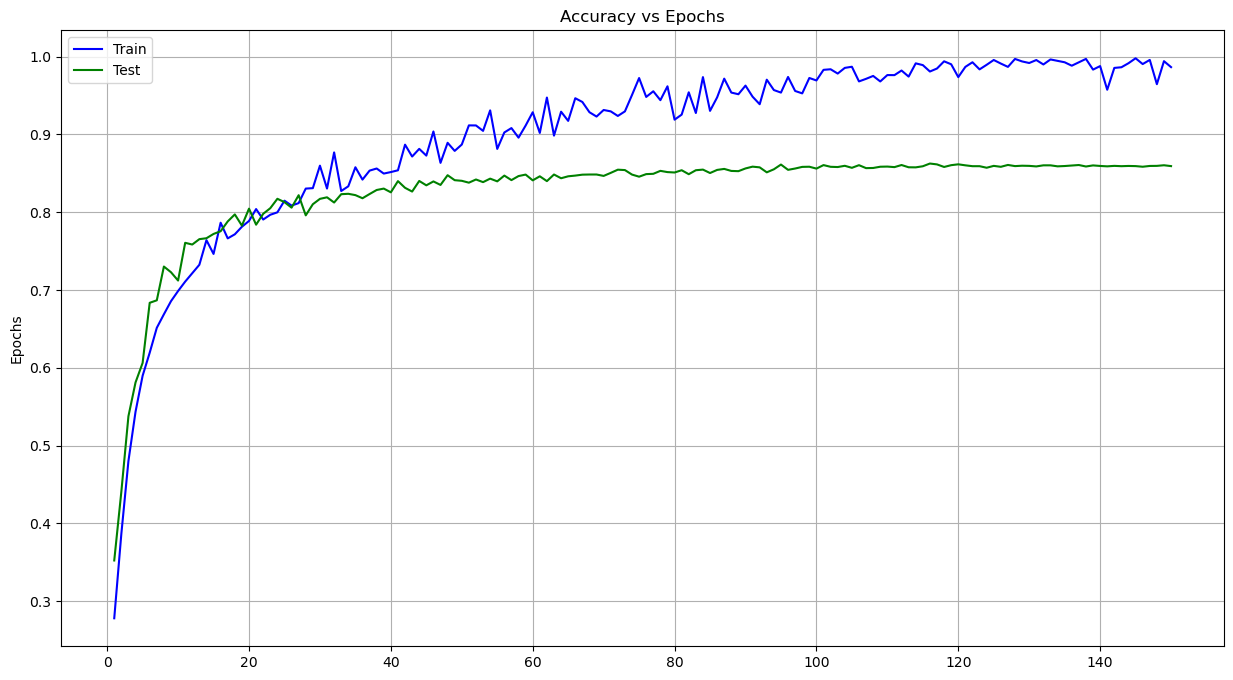

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_accu,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_accu ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Accuracy")
plt.ylabel('Epochs')
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

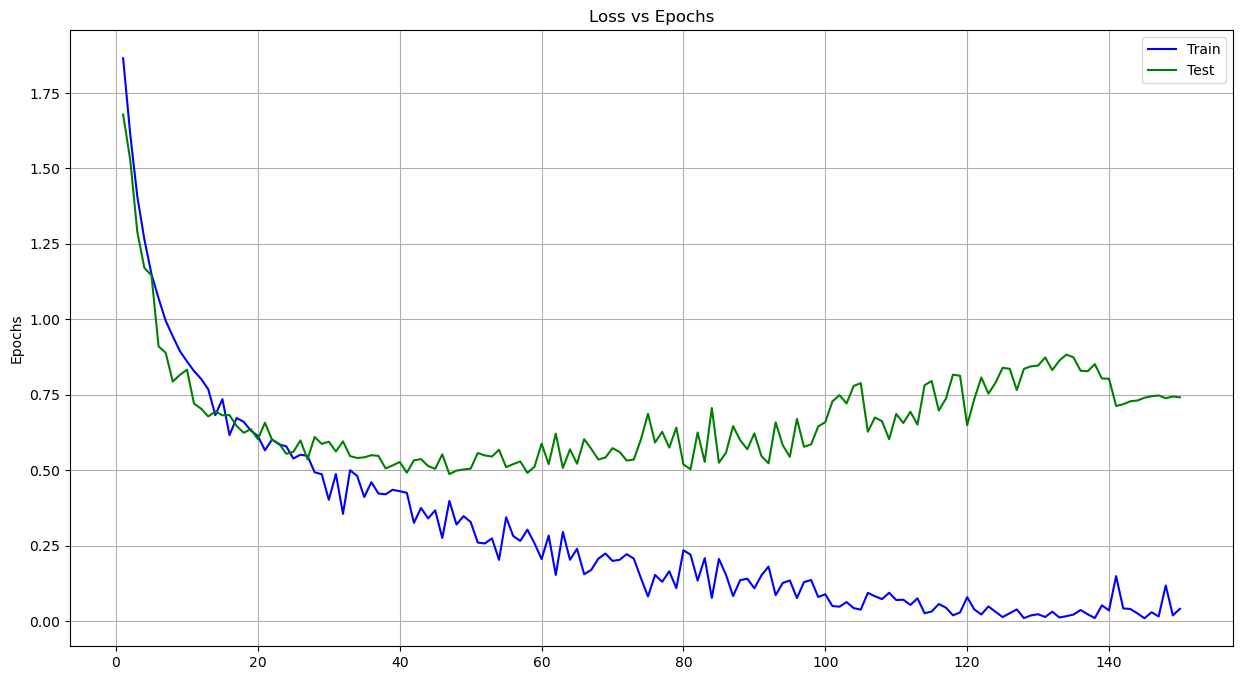

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, train_loss,c='blue', linestyle = '-', label = 'Train')
plt.plot(epochs, test_loss ,c='green', linestyle = '-', label = 'Test')
plt.ylabel("Loss")
plt.ylabel('Epochs')
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()